# Notebook for knowledge tracing by subjects

## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

In [6]:
# Import the tables of the data set as dataframes.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection, metrics

# PyBKT package imports
from pyBKT.models import Model

# PyAFM package imports
from pyafm.custom_logistic import CustomLogistic

DATA_DIR = 'data' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [7]:
topics=pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
topics_trees=pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
documents=pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
learn_sessions=pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))

In [8]:
transactions['user_id']=transactions['user_id'].astype(int)

## Task 1: Data Preprocessing

5-steps approach of preprocessing data:

1. Ways of considering partial answers:
    - as 1 (incorrect)
    - as 0 (correct)
    
2. Answers:
    - can be given only on tasks of type 'level check'
    - can be given on all types of tasks

3. Acceptance of session:
    - consider only accepted sessions
    - consider 
    
4. Closeness of session:
    - closed
    - any

5. Filter users:
    - allow any number of sessions
    - only users with many sessions

In [26]:
learn_transaction=pd.merge(learn_sessions,transactions[['transaction_id','user_id','evaluation']],on='transaction_id').copy()

In [27]:
learn_transaction.shape

(497263, 9)

In [28]:
#We assume that answers can be given only on tasks of type check and no answers on tasks of type learn
learn_transaction=learn_transaction[((learn_transaction['type_id']==2)  & (learn_transaction['evaluation'].notna())) | ((learn_transaction['type_id']==1)  & (learn_transaction['evaluation'].isna()))].copy()

In [29]:
learn_transaction.shape

(211541, 9)

In [30]:
learn_transaction['correct']=learn_transaction['evaluation'].fillna(-1) #not given
learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') ,1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as incorrect
#learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') & (learn_transaction['correct']=='PARTIAL'),1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as correct

In [31]:
learn_transaction=pd.merge(learn_transaction,topics,left_on='topic_id',right_on='id').copy()

In [32]:
#closeness of sessions
#learn_transaction=learn_transaction[learn_transaction['is_closed']==1].reset_index().copy()

In [33]:
learn_transaction=learn_transaction[learn_transaction['is_accepted']==1].reset_index().copy()

In [34]:
learn_transaction.shape

(158021, 17)

In [35]:
learn_transaction['subject']=np.where(learn_transaction['math']==1,'Math','German')

In [64]:
df_subject=learn_transaction[['user_id','learn_session_id','transaction_id','subject','correct']].sort_values(by=['learn_session_id','transaction_id'],ascending=True)
df_subject=df_subject.rename(columns={"subject": "skill_name"}).copy()

In [65]:
df_subject['prior_success']=np.where(df_subject.correct==1,1,0)
df_subject['prior_failure']=np.where(df_subject.correct==0,1,0)
df_subject['prior_success']=df_subject.groupby(['user_id','skill_name']).prior_success.cumsum()-1
df_subject['prior_success']=df_subject['prior_success'].apply(lambda x: 0 if x<0 else x)
df_subject['prior_failure']=df_subject.groupby(['user_id','skill_name']).prior_failure.cumsum()-1
df_subject['prior_failure']=df_subject['prior_failure'].apply(lambda x: 0 if x<0 else x)

In [66]:
df_subject.reset_index(inplace=True,drop=True)
df_subject.head(20)

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
0,387605,5297,385885,Math,-1,0,0
1,387605,5301,385899,Math,-1,0,0
2,387605,5309,385955,German,-1,0,0
3,387605,5432,387905,German,-1,0,0
4,387605,5433,387906,German,-1,0,0
5,387605,5436,387921,German,-1,0,0
6,387605,5444,387954,Math,-1,0,0
7,387605,5445,387962,Math,-1,0,0
8,387615,5542,388166,German,1,0,0
9,387615,5542,388167,German,1,1,0


In [67]:
df_subject.shape

(158021, 7)

In [68]:
user_activity=df_subject.groupby('user_id').count().sort_values(by='correct').copy()

In [70]:
#user_activity=df_subject.groupby('user_id').count().sort_values(by='correct').copy()
#exclude_users=user_activity[user_activity['correct']>=20].index #top 30% of users by number of answers
exclude_users=user_activity.index.to_frame().sample(2500).index #random 2500 of users
df_subject=df_subject[df_subject['user_id'].isin(exclude_users)].copy()

In [71]:
df_subject.shape

(57326, 7)

## Task 2: Model Building
----
In this section, we will perform: 

(i) a Bayesian Knowledge Tracing (BKT) model, 

(ii) an Additive Factor Model (AFM),

(iii) a Performance Factor Analysis (PFA) model and

(iv) a Deep learning knowledge tracing (DKT) model<br>
on the skills 'Math', and 'German'

We will complete this section through five main tasks:

Task 2.1: Group k-fold initialization.

Task 2.2: BKT evaluation.

Task 2.3: AFM evaluation.

Task 2.4: PFA evaluation.

Task 2.5: DKT evaluation.

We take a look at the skills included in the data set:

In [19]:
df_subject['skill_name'].unique()

array(['Math', 'German'], dtype=object)

### Task 2.1

In [20]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 2 folds, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupKFold(n_splits=2).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator.

In [21]:
tested_user_ids = set()
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    user_ids = df_subject['user_id'].unique()
    train_user_ids = df_subject.iloc[train_index]['user_id'].unique()
    test_user_ids = df_subject.iloc[test_index]['user_id'].unique()
    print('Iteration:', iteration)
    print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
    print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
    print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
    tested_user_ids = tested_user_ids.union(set(test_user_ids))

Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()
Iteration: 1
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()


On a given iteration, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.

### Task 2.2

In this task we evaluate a `BKT model` with all default parameters in pyBKT, through a `k-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [22]:
rmse_bkt, auc_bkt = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    
    # Split data in training and test sets
    X_train, X_test = df_subject.iloc[train_index], df_subject.iloc[test_index]
    
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train) 
    
    # Compute RMSE
    train_rmse = model.evaluate(data=X_train, metric='rmse')
    test_rmse = model.evaluate(data=X_test, metric='rmse')
    rmse_bkt.append(test_rmse)
    
    # Compute AUC
    train_auc = model.evaluate(data=X_train, metric='auc')
    test_auc = model.evaluate(data=X_test, metric='auc')
    auc_bkt.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 7.83 s, sys: 0 ns, total: 7.83 s
Wall time: 8.1 s
Iteration: 0 RMSE (0.4848772693922072, 0.48539908218794525) AUC (0.6321484053078985, 0.6311698419372282)
CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 11 s
Iteration: 1 RMSE (0.48516188150435685, 0.48496422632768027) AUC (0.6341761680973415, 0.6341331177331795)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [23]:
print('For BKT model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_bkt),5), round(np.std(rmse_bkt),5)))
print('For BKT model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_bkt),5), round(np.std(auc_bkt),5)))

For BKT model mean RMSE=0.48518 and standard deviation of RMSE is 0.00022
For BKT model mean AUC=0.63265 and standard deviation of AUC is 0.00148


In [24]:
df_subject = df_subject[df_subject['correct'] != -1].copy()
df_subject.shape

(112546, 7)

### Task 2.3

In this task we evaluate an `AFM model` with all default parameters through a `k-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [25]:
def read_as_student_step(data):    
    skills, opportunities, corrects, user_ids = [], [], [], []
    
    for row_id, (_, row) in enumerate(data.iterrows()):
        
        # Get attributes for the current interaction 
        user_id = row['user_id']
        skill_name = row['skill_name']
        correct = row['correct']
        prior_success = row['prior_success']
        prior_failure = row['prior_failure']
        
        # Update the number of opportunities this student had with this skill
        opportunities.append({skill_name: prior_success + prior_failure})
        
        # Update information in the current 
        skills.append({skill_name: 1})

        # Answer info
        corrects.append(correct)
        
        # Student info
        user_ids.append({user_id: 1})
        
    return (skills, opportunities, corrects, user_ids)

In [26]:
def prepare_data_afm(skills, opportunities, corrects, user_ids):

    sv = feature_extraction.DictVectorizer()
    qv = feature_extraction.DictVectorizer()
    ov = feature_extraction.DictVectorizer()
    S = sv.fit_transform(user_ids)
    Q = qv.fit_transform(skills)
    O = ov.fit_transform(opportunities)
    X = sc.sparse.hstack((S, Q, O))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the AFM model. 

In [27]:
%time skills, opportunities, corrects, user_ids = read_as_student_step(df_subject)
%time X, y = prepare_data_afm(skills, opportunities, corrects, user_ids)

CPU times: user 5.49 s, sys: 0 ns, total: 5.49 s
Wall time: 5.63 s
CPU times: user 936 ms, sys: 2.3 s, total: 3.24 s
Wall time: 4.58 s


In [28]:
X.shape

(112546, 2541)

In [29]:
rmse_afm, auc_afm = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(X_train.shape,X_test.shape)
    
    # Initialize and fit the model
    afm = CustomLogistic()
    %time afm.fit(X_train, y_train)
    
    # Make predictions 
    y_train_pred = afm.predict_proba(X_train)
    y_test_pred = afm.predict_proba(X_test)
    
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_afm.append(test_rmse)
    
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_afm.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

(56273, 2541) (56273, 2541)
CPU times: user 4min 35s, sys: 1min 32s, total: 6min 8s
Wall time: 8min 19s
Iteration: 0 RMSE (0.47175224887113526, 0.4969197439162808) AUC (0.6824996745678189, 0.5434695631545426)
(56273, 2541) (56273, 2541)
CPU times: user 6min 51s, sys: 1min 51s, total: 8min 42s
Wall time: 10min 57s
Iteration: 1 RMSE (0.469460424476393, 0.49638262316598186) AUC (0.690225870586761, 0.5458870186413644)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [30]:
print('For AFM model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_afm),5), round(np.std(rmse_afm),5)))
print('For AFM model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_afm),5), round(np.std(auc_afm),5)))

For AFM model mean RMSE=0.49665 and standard deviation of RMSE is 0.00027
For AFM model mean AUC=0.54468 and standard deviation of AUC is 0.00121


### Task 2.4

In this task we evaluate a `PFA model` with all default parameters through a `k-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [31]:
def read_as_success_failure(data):
    n_succ, n_fail = [], []

    # Create the n_succ and n_fail variables required by pyAFM
    for i, row in data.iterrows():
        n_succ.append({row['skill_name']: int(row['prior_success'])})
        n_fail.append({row['skill_name']: int(row['prior_failure'])})
        
    return n_succ, n_fail

In [32]:
def prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail):
    
    s = feature_extraction.DictVectorizer()
    q = feature_extraction.DictVectorizer()
    succ = feature_extraction.DictVectorizer()
    fail = feature_extraction.DictVectorizer()
    S = s.fit_transform(user_ids)
    Q = q.fit_transform(skills)
    succ = succ.fit_transform(n_succ)
    fail = fail.fit_transform(n_fail)
    X = sc.sparse.hstack((S, Q, succ, fail))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the PFA model. 

In [33]:
%time n_succ, n_fail = read_as_success_failure(df_subject)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 5.85 s, sys: 585 ms, total: 6.44 s
Wall time: 14 s
CPU times: user 1.84 s, sys: 1.27 s, total: 3.11 s
Wall time: 15.1 s


In [34]:
X.shape

(112546, 2543)

In [35]:
rmse_pfa, auc_pfa = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and fit the model
    pfa = CustomLogistic()
    %time pfa.fit(X_train, y_train)
    # Make predictions 
    y_train_pred = pfa.predict_proba(X_train)
    y_test_pred = pfa.predict_proba(X_test)
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_pfa.append(test_rmse)
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_pfa.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 4min 15s, sys: 1min 13s, total: 5min 29s
Wall time: 7min 38s
Iteration: 0 RMSE (0.46895961610203324, 0.4798329240704865) AUC (0.6922544401247408, 0.6772457597060666)
CPU times: user 4min 18s, sys: 1min 15s, total: 5min 33s
Wall time: 9min 48s
Iteration: 1 RMSE (0.4670917014552567, 0.48117159805365195) AUC (0.6984853016428934, 0.6714688667446533)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds. 

In [36]:
print('For PFA model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_pfa),5), round(np.std(rmse_pfa),5)))
print('For PFA model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_pfa),5), round(np.std(auc_pfa),5)))

For PFA model mean RMSE=0.4805 and standard deviation of RMSE is 0.00067
For PFA model mean AUC=0.67436 and standard deviation of AUC is 0.00289


### Task 2.5

In this task we evaluate a `DKT model` with 10 epochs, computing the following performance metrics: `RMSE` and `AUC`.

In [37]:
import tensorflow as tf

In [38]:
def prepare_seq(df):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4- Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth

In [39]:
def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)

In [40]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

In [41]:
# Obtain indexes
train_index, test_index = next(create_iterator(df_subject))
# Split the data
X_train, X_test = df_subject.iloc[train_index], df_subject.iloc[test_index]

In [42]:
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

seq, features_depth, skill_depth = prepare_seq(df_subject)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

2022-05-02 22:14:53.661630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 22:14:53.685294: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 22:14:53.687951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noto.epfl.ch): /proc/driver/nvidia/version does not exist
2022-05-02 22:14:55.508194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [44]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [45]:
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

In [46]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = tf.keras.layers.SimpleRNN(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [47]:
model.summary()


Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 4)]         0         
                                                                 
 masking (Masking)           (None, None, 4)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          336       
                                                                 
 outputs (TimeDistributed)   (None, None, 1)           17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [48]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10
39/39 [==============================] - 179s 659ms/step - loss: 0.6347 - auc: 0.4913 - root_mean_squared_error: 0.5522 - val_loss: 0.6417 - val_auc: 0.5016 - val_root_mean_squared_error: 0.5494
Epoch 2/10
39/39 [==============================] - 21s 538ms/step - loss: 0.6295 - auc: 0.5104 - root_mean_squared_error: 0.5439 - val_loss: 0.6382 - val_auc: 0.5331 - val_root_mean_squared_error: 0.5438
Epoch 3/10
39/39 [==============================] - 22s 574ms/step - loss: 0.6276 - auc: 0.5313 - root_mean_squared_error: 0.5406 - val_loss: 0.6371 - val_auc: 0.5403 - val_root_mean_squared_error: 0.5420
Epoch 4/10
39/39 [==============================] - 22s 574ms/step - loss: 0.6269 - auc: 0.5379 - root_mean_squared_error: 0.5395 - val_loss: 0.6366 - val_auc: 0.5421 - val_root_mean_squared_error: 0.5412
Epoch 5/10
39/39 [==============================] - 23s 578ms/step - loss: 0.6269 - auc: 0.5387 - root_mean_squared_error: 0.5393 - val_loss: 0.6364 - val_auc: 0.5432 - val_root_m

In [49]:
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

39/39 [==============================] - 7s 176ms/step - loss: 0.6362 - auc: 0.5516 - root_mean_squared_error: 0.5390


In [50]:
# Binary cross entropy, AUC, RMSE
metrics_dkt_small

[0.6361716389656067, 0.5516229271888733, 0.5389877557754517]

In [51]:
auc_dkt = np.empty(np.shape(auc_bkt))
auc_dkt.fill(metrics_dkt_small[1])

rmse_dkt = np.empty(np.shape(rmse_bkt))
rmse_dkt.fill(metrics_dkt_small[2])

## Task 3: Model Evaluation
---
In this task, we use metrics to evaluate the model.

By performing a user-stratified k-fold cross validation and monitoring the Root Mean Squared Error (RMSE) and the Area Under the ROC Curve (AUC) as performance metrics. Then, we visually report the RMSE and AUC scores achieved by the student's models in the user-stratified 2-fold cross validation, in such a way that the models' performance can be easily and appropriately compared against each other.

Task 3.1: Performance metrics plotting.

Task 3.2: Performance metrics discussion.


### Task 3.1 Metrics representation

In this task, we visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 2-fold cross validation performed in Task 1.2, 1.3, 1.4 and 1.5 respectively, in such a way that the models' performances can be easily and appropriately compared against each other. 

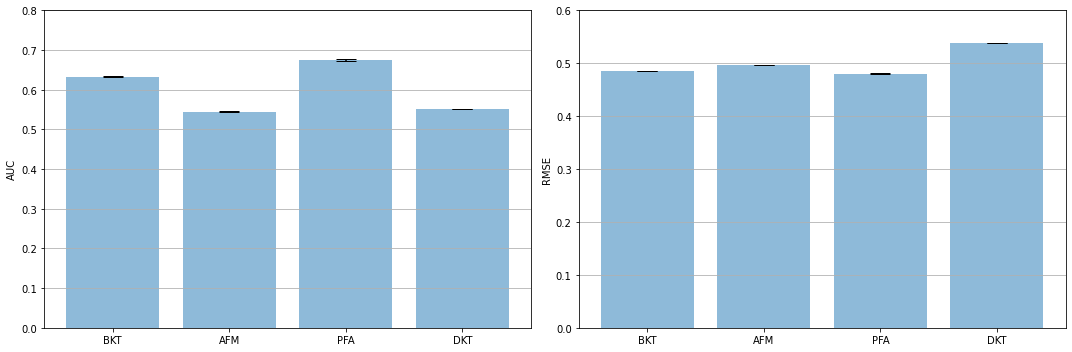

In [52]:
m = {'AUC': {'BKT': auc_bkt, 'AFM': auc_afm, 'PFA': auc_pfa, 'DKT': auc_dkt}, 'RMSE': {'BKT': rmse_bkt, 'AFM': rmse_afm, 'PFA': rmse_pfa, 'DKT': rmse_dkt}}
limits = {'AUC': 0.8, 'RMSE': 0.6}

plt.figure(figsize=(15, 5))

for metric_idx, metric_key in enumerate(m.keys()):
    
    # Create the subplot for the current metric
    plt.subplot(1, len(m), metric_idx + 1)
    # Compute means, standard deviations, and labels
    means, errors, labels = [], [], []
    for model_key, model_scores in m[metric_key].items():
        means.append(np.mean(model_scores))
        errors.append(np.std(model_scores))
        labels.append(model_key)
    
    # Plot values
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
    # Make decorations
    plt.grid(axis='y')
    plt.xticks(x_pos, labels)
    plt.ylabel(metric_key)
    plt.ylim(0, limits[metric_key])

# Show the plot
plt.tight_layout()
plt.show()

### Task 3.2 Metrics discussion

From the left plot, it can be observed that the PFA model exhibited a higher AUC score (around 0.68) and a lower standard deviation of AUC score across folds with respect to AFM, BKT and DKT models, indicating that the predictive power of the PFA model is higher and more stable across folds than the one of the other two models, when AUC is considered. 

Similarly, the right plot highlights that the PFA model performs better, on average, with respect to AFM, BKT and DKT in terms of RMSE, i.e., the RMSE score is lower for the PFA model (0.48). AFM, BKT and DKT were able to achieve an average RMSE score of 0.5, 0.49 and 0.55 respectively. The standard deviation in performance across folds is quite small for all four models.        

Based on our results, we can generally observe that the characteristics and properties of the PFA model allow us to make better estimations of student’s subject mastery, compared to the three other considered models. One reason behind this finding might be that the skills at hand seem to meet well PFA assumptions, specifically that (i) studetns may initially know more or less , (ii) students learn at the same rate, (iii) students learning rate differs for correct and wrong practive opportunitites, (iv) each item belongs to one or more skills.

### Learning Curves Comparison 
----

In this section, we fit a PFA (as soon as it achieved the best performance through all other models) model on all the skills. Then, for each skill we visually report and discuss (i) the learning curve and (ii) the bar plot representing the number of students who reached a given number of opportunities for that skill,  obtained with the PFA model fitted on the above-mentioned skills, in such a way that they can be easily and appropriately compared. 

This section is divided in three main tasks:
- Task 3.3: PFA fit and prediction. 
- Task 3.4: Learning curves and bar plots generation.
- Task 3.5: Learning curves and bar plots discussion. 

### Task 3.3

In [74]:
df_subject_last=df_subject.iloc[0:80000,:].copy()

In [75]:
%time skills, opportunities, corrects, user_ids = read_as_student_step(df_subject_last)
%time n_succ, n_fail = read_as_success_failure(df_subject_last)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 3.95 s, sys: 253 ms, total: 4.2 s
Wall time: 4.44 s
CPU times: user 3.69 s, sys: 203 ms, total: 3.89 s
Wall time: 3.98 s
CPU times: user 648 ms, sys: 1.12 s, total: 1.77 s
Wall time: 1.79 s


In [76]:
X.shape

(80000, 2025)

In [77]:
# Initialize the model
pfa = CustomLogistic()

# Fit the model on the entire dataset
%time pfa.fit(X, y)

CPU times: user 7min 57s, sys: 1min 29s, total: 9min 27s
Wall time: 9min 36s


CustomLogistic()

In [78]:
# Make predictions
predictions_proba=pfa.predict_proba(X)

# Rename the dataframe columns as per instructions
predictions=df_subject_last[['user_id','skill_name','correct']].copy()
predictions.columns=['user_id','skill_name','y_true']
predictions['y_pred_pfa']=predictions_proba

In [79]:
predictions.head()

,user_id,skill_name,y_true,y_pred_pfa
8,387615,German,1,0.50513
9,387615,German,1,0.51155
10,387615,German,0,0.51155
11,387615,German,1,0.51795
12,387615,German,0,0.51146


### Task 3.4 Learning curves visualization

In this task we visually report and discuss 

(i) the `learning curve` and 

(ii) the `bar plot` representing the number of students who reached a given number of opportunities, <br>
obtained by the PFA model fitted on that skill, in such a way that they can be easily and appropriately compared.

In [80]:
def avg_y_by_x(x, y):
    # Transform lists into arrays
    x = np.array(x)
    y = np.array(y)

    # Sort the integer id representing the number of opportunities in increasing order
    xs = sorted(list(set(x)))

    # Supporting lists to store the:
    # - xv: integer identifier of the number of opportunities
    # - yv: average value across students at that number of opportunities
    # - lcb and ucb: lower and upper confidence bound
    # - n_obs: number of observartions present at that number of opportunities (on per-skill plots, it is the #students)
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []

    # For each integer identifier of the number of opportunities 0, ...
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] # We retrieve the values for that integer identifier
        if len(ys) > 0: 
            xv.append(v) # Append the integer identifier of the number of opportunities
            yv.append(sum(ys) / len(ys)) # Append the average value across students at that number of opportunities
            n_obs.append(len(ys)) # Append the number of observartions present at that number of opportunities

            
            # Prepare data for confidence interval computation
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            # Calculate the 95% confidence intervals
            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

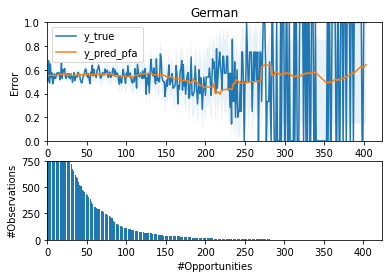

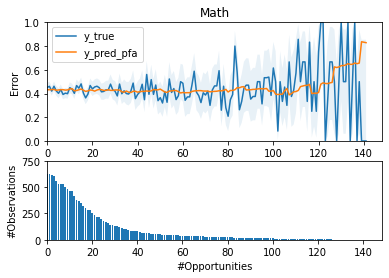

In [81]:
for plot_id, skill_name in enumerate(df_subject_last['skill_name'].unique()): # For each skill under consideration
    
    preds = predictions[predictions['skill_name'] == skill_name] # Retrieve predictions for the current skill

    xp = []
    yp = {}
    for col in preds.columns: # For y_true and and y_pred_bkt columns, initialize an empty list for curve values
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): # For each user
        user_preds = preds[preds['user_id'] == user_id] # Retrieve the predictions on the current skill for this user 
        xp += list(np.arange(len(user_preds))) # The x-axis values go from 0 to |n_opportunities|-1
        for col in preds.columns: 
            if 'y_' in col: # For y_true and and y_pred_bkt columns
                yp[col] += user_preds[col].tolist() # The y-axis value is the success rate for this user at that opportunity

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) # Initialize the plotting figure

    lines = []
    for col in preds.columns:
        if 'y_' in col: # For y_true and and y_pred_bkt columns   
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) # Calculate mean and 95% confidence intervals for success rate 
            y = [1-v for v in y] # Transform success rate in error rate
            if col == 'y_true': # In case of ground-truth data, we also show the confidence intervals
                axs[0].fill_between(x, lcb, ucb, alpha=.1)
            model_line, = axs[0].plot(x, y, label=col) # Plot the curve
            lines.append(model_line) # Store the line to then set the legend    

    # Make decorations for the learning curve plot
    axs[0].set_title(skill_name)
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(0, None)

    # Plot the number of observations per number of opportunities bars and make decorations
    axs[1].set_xlabel('#Opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('#Observations')
    axs[1].set_ylim(0, 750)
    axs[1].set_xlim(0, None)

    # Plot the learning curve and the bar plot 
    plt.show()

### Task 3.5

- "**Math**". From the error rate in the ground-truth data (y_true, blue), it can be observed that this skill appears quite hard for students, with an initial error rate of around 0.45 in the first opportunity. The error rate does not go down, as we would usually expect, it stays stable with some alternations. With #opportunities the confidence interval increases, especially starting from value 50. After 110 opportunities error rte starts jumping between 0 and 1 as far as there are no many participants no more. 

- "**German**". Based on the patterns of the ground-truth data (y_true, blue), the error rate observed for this skill at the earlier stages is of around 0.60. For the many number of opportunities (until it reaches 100) students almost have no success in this skill and the cconfidence interval is quite small. Afterwards the confidence interval starts increasing, while error rate falls to approximately 0.5. After 200 opportunities the behaviour of these curve is almost unpredictable.

For both Math and German the amount of students decreases slowly. Predictions obtained by PFA model are good and catch the main trend as far as there is enough data.